# How to estimate model parameters with MSM

This guide contains an estimation exercise for the use of [respy](https://respy.readthedocs.io/en/latest/)'s method of simulated moments interface with [estimagic](https://estimagic.readthedocs.io/en/latest/)'s optimization capabilities.

The theoretical basis for the Method of Simulated Moments (MSM) can be found in McFadden (1989). A detailed guide to the MSM interface in `respy` is linked below. It provides a overview of `respy`'s MSM functions and outlines how inputs may be specified to construct a criterion function. This guide as a next step showcases a small estimation exercise to estimate parameters with the specified criterion function.

# Motivation

Estimation of structural models is a tedious and complicated task, as we attempt to optimize a usually non-smooth criterion function with respect to a large number of parameters. Optimizers may easily get stuck in local optima for such criterion functions, preventing us from finding a global solution. It is therefore worthwhile to make sure an estimation setup is correctly specified.

The purpose of this exercise is to demonstrate how we can check in a very controlled environment whether an estimation procedure and criterion function are correctly specified for the estimation of a model. This notebook, therefore, is **not** a guide to estimating a model in general but instead showcases a test of the setup that should precede actual estimation. The exercise also allows us to get a sense of how sensitive the estimation process is to different calibration choices  in the optimization like bounds and algorithms, as well as the specification of the criterion function in regards to the choice of weighting matrix, the set of moments, or size of the simulated sample.

In the exercise, we will work with a simulated model which we have complete control of  and for which we know the true parameter vector. We will attempt to estimate a misspecified version of the model to perturb the true parameter vector in a controlled fashion and then try to retrieve the parameters for the correct model specification using the perturbed vector as starting values. The exercise thus allows us to test whether the general setup of our optimization problem works and an optimizer is successful in approaching the optimum for a correctly specified model (Eisenhauer et al., 2015; Eisenhauer, 2019).

In [1]:
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from pathlib import Path

import respy as rp
from respy.method_of_simulated_moments import _harmonize_input
from estimagic.logging.create_database import load_database
from estimagic.logging.read_database import read_last_iterations
from estimagic import minimize

<IPython.core.display.Javascript object>

# Setup Estimation

## Configure MSM Inputs

To configure the MSM criterion function for estimation, we need to specify a model that will be passed on to the simulator, define moment and replacement functions, derive empirical moments, and specify a weighting matrix. We will use ``respy``'s `kw_94_one` example model for the exercise, which is based on a model specification from Keane and Wolpin (1994). The following section will outline all the inputs needed to set up the estimation.

Note that this model is simulated, which gives us complete control of all aspects of the model as we can determine the data generating process of not only the simulated data, but the observed data as well.

### Model

We can generate the model using `respy`'s `get_example_model` function. We will treat the parameter vector from this specification as the *true* parameter vector that we will try to retrieve during estimation. With it comes our *observed data* that is generated using the true parameters and which we will match simulated moments generated from candidate parameter vectors to during estimation.

In [2]:
params, options, data_obs = rp.get_example_model("kw_94_one")

<IPython.core.display.Javascript object>

### Moment & Replacement Functions

Aside from the parameters and options that are used to define the model, we need to define functions to compute moments and to replace missing moments for the simulated data we generate for candidate parameter vectors during estimation.

In [3]:
def calc_choice_frequencies(df):
    """Calculate choice frequencies."""
    return df.groupby("Period").Choice.value_counts(normalize=True).unstack()


def calc_wage_distribution(df):
    """Calculate wage distribution."""
    return df.groupby(["Period"])["Wage"].describe()[["mean", "std"]]


def replace_nans(df):
    """Replace missing values in data."""
    return df.fillna(0)

<IPython.core.display.Javascript object>

We save the arguments in dictionaries to later pass on to the criterion function. The function ``replace_nans`` can be left as it is because we only use one replacement function for all moments.

In [4]:
calc_moments = {
    "Choice Frequencies": calc_choice_frequencies,
    "Wage Distribution": calc_wage_distribution,
}

<IPython.core.display.Javascript object>

### Empirical Moments

Now that we have defined the functions needed to compute moments, we can use them to compute the empirical or observed moments for our data. We apply the replacement function to the empirical moments as well.

In [5]:
empirical_moments = {
    "Choice Frequencies": replace_nans(calc_choice_frequencies(data_obs)),
    "Wage Distribution": replace_nans(calc_wage_distribution(data_obs)),
}

<IPython.core.display.Javascript object>

### Weighting Matrix

Additionally we compute a diagonal variance weighting matrix using a bootstrapping procedure using the function below.

In [6]:
def get_weighting_matrix(
    data,
    empirical_moments,
    calc_moments,
    n_bootstrap_samples,
    n_observations_per_sample,
    replace_missing_variances=None,
):
    """ Computes a diagonal weighting matrix for estimation with msm. Weights are the
    inverse bootstrap variances of the observed sample moments."""
    # Seed for reproducibility.
    np.random.seed(123)
    flat_empirical_moments = rp.get_flat_moments(empirical_moments)
    index_base = data.index.get_level_values("Identifier").unique()
    calc_moments = _harmonize_input(calc_moments)
    # Create bootstrapped moments.
    moments_sample = []
    for _ in range(n_bootstrap_samples):
        ids_boot = np.random.choice(
            index_base, n_observations_per_sample, replace=False
        )
        moments_boot = [func(data.loc[ids_boot]) for func in calc_moments]
        flat_moments_boot = rp.get_flat_moments(moments_boot)
        flat_moments_boot = flat_moments_boot.reindex_like(flat_empirical_moments)
        moments_sample.append(flat_moments_boot)

    # Compute variance for each moment and construct diagonal weighting matrix.
    moments_var = np.array(moments_sample).var(axis=0)

    # The variance of missing moments is nan. Unless a repalcement variance is
    # specified, their inverse variance will be set to 0.
    if replace_missing_variances is None:
        diagonal = moments_var ** (-1)
        diagonal = np.nan_to_num(diagonal, nan=0)
        weighting_matrix = np.diag(diagonal)
    else:
        moments_var = np.nan_to_num(moments_var, nan=replace_missing_variances)
        diagonal = moments_var ** (-1)
        weighting_matrix = np.diag(diagonal)

    # Checks weighting matrix.
    if np.isnan(weighting_matrix).any() or np.isinf(weighting_matrix).any():
        raise ValueError("Weighting matrix contains NaNs or infinite values.")

    return weighting_matrix

<IPython.core.display.Javascript object>

In [7]:
weighting_matrix = get_weighting_matrix(
    data=data_obs,
    empirical_moments=empirical_moments,
    calc_moments=calc_moments,
    n_bootstrap_samples=300,
    n_observations_per_sample=500,
)

<IPython.core.display.Javascript object>

### Criterion Function

Now that we have specified all inputs, we can pass them on to respy's `get_msm_func` to generate the criterion function. So far, this guide has just repeated the steps outlined in the general [method of simulated moments](https://respy.readthedocs.io/en/latest/how_to_guides/msm.html) guide (with the exception of the choice of weighting matrix).

In [8]:
criterion_msm = rp.get_msm_func(
    params=params,
    options=options,
    calc_moments=calc_moments,
    replace_nans=replace_nans,
    empirical_moments=empirical_moments,
    weighting_matrix=weighting_matrix,
)

<IPython.core.display.Javascript object>

## Configure optimization

In the next step we address the elements that are needed for optimization of the criterion function. These specifications are undertaken specifically for estimation with estimagic. Other optimization packages might require different configurations. 

### Add bounds to parameters

As a first step we define bounds for our parameter vector that aid the optimizer in estimation. Depending on the model, some parameters may have natural bounds that can be used (i.e. the discount factor ranges between 0 and 1). The choice of bounds is a decisive factor in the success of optimization and may require many adjustments during an actual estimation process when the true parameter values are unknown.

Since this is a simulation exercise, we know the true parameter value and can define our bounds accordingly.

In [9]:
def add_params_bounds(params, deviation):
    """ Add upper and lower bounds in parameter vector for optimization."""
    params = params.copy()
    # Compute relative deviation of parameter values as bounds.
    params["lower"] = params["value"] - abs((params["value"] * deviation))
    params["upper"] = params["value"] + abs((params["value"] * deviation))

    # Parameters with value 0 get the absolute deviation as bounds.
    params["upper"] = params["upper"].replace(0, deviation)
    params["lower"] = params["lower"].replace(0, -deviation)

    # Bounds for specififc parameters, shocks do not get bounds.
    params.loc[("delta", "delta"), ("lower", "upper")] = (0, 1)
    params.loc["shocks_sdcorr", ("lower", "upper")] = (-(np.inf), np.inf)

    return params

<IPython.core.display.Javascript object>

Below we select bounds that constitute a 5% deviation from the true values (or an absolute deviation of 0.05 for parameters that are 0 at the true value. Note that the bounds should be named ``lower`` and ``upper`` so ``estimagic`` can recognize them as bounds.

In [10]:
params = add_params_bounds(params, 0.05)

<IPython.core.display.Javascript object>

In [11]:
params

value  \
category                name                                   
delta                   delta                         0.9500   
wage_a                  constant                      9.2100   
                        exp_edu                       0.0380   
                        exp_a                         0.0330   
                        exp_a_square                 -0.0005   
                        exp_b                         0.0000   
                        exp_b_square                  0.0000   
wage_b                  constant                      8.4800   
                        exp_edu                       0.0700   
                        exp_b                         0.0670   
                        exp_b_square                 -0.0010   
                        exp_a                         0.0220   
                        exp_a_square                 -0.0005   
nonpec_edu              constant                      0.0000   
                        at_least_twelve_exp_edu       0.0000   
                        not_edu_last_period       -4000.0000   
nonpec_home             constant                  17750.0000   
shocks_sdcorr           sd_a                          0.2000   
                        sd_b                          0.2500   
                        sd_edu                     1500.0000   
                        sd_home                    1500.0000   
                        corr_b_a                      0.0000   
                        corr_edu_a                    0.0000   
                        corr_edu_b                    0.0000   
                        corr_home_a                   0.0000   
                        corr_home_b                   0.0000   
                        corr_home_edu                 0.0000   
lagged_choice_1_edu     probability                   1.0000   
initial_exp_edu_10      probability                   1.0000   
maximum_exp             edu                          20.0000   
inadmissibility_penalty inadmissibility_penalty -400000.0000   

                                                                                           comment  \
category                name                                                                         
delta                   delta                                                      discount factor   
wage_a                  constant                                               log of rental price   
                        exp_edu                          return to an additional year of schooling   
                        exp_a                                     return to same sector experience   
                        exp_a_square                   return to same sector, quadratic experience   
                        exp_b                                    return to other sector experience   
                        exp_b_square                  return to other sector, quadratic experience   
wage_b                  constant                                               log of rental price   
                        exp_edu                          return to an additional year of schooling   
                        exp_b                                     return to same sector experience   
                        exp_b_square                   return to same sector, quadratic experience   
                        exp_a                                    return to other sector experience   
                        exp_a_square                  return to other sector, quadratic experience   
nonpec_edu              constant                            constant reward for choosing education   
                        at_least_twelve_exp_edu        reward for going to college (tuition, etc.)   
                        not_edu_last_period                        reward for going back to school   
nonpec_home             constant                         constant reward of non-market alternative   
shoc

<IPython.core.display.Javascript object>

### Create configuration dictionary for optimization

There are additional arguments we need to pass on to the optimizer like the optimization algorithm and  constraints. We can get the constraints for the selected model from `respy` using the function `get_parameter_constraints`. We collect the elements in a dictionary that can be passed on to the optimizer.

In [12]:
optim_config = {
    "algorithm": "nlopt_bobyqa",
    "constraints": rp.get_parameter_constraints("kw_94_one"),
}

<IPython.core.display.Javascript object>

### Logging

``estimagic`` creates a database file for each optimization it conducts. The database file contains useful information about the optimization process like the criterion and parameter values at each iteration. In order to save the databases for each optimization and prevent them from being overwritten when a new optimization is launched, we can define a function that creates a logging path based on the current date and time to ensure a unique logging path for each optimization.

In [13]:
def create_logging_path(target_dir):
    """Creates a directory in the target_dir based on current date and time."""
    cwd = Path.cwd()
    time = datetime.now().strftime("%d.%m.%Y_%H-%M-%S")
    target = cwd / target_dir / time
    target.mkdir(parents=True, exist_ok=True)
    return str(target)

<IPython.core.display.Javascript object>

In [14]:
logging_path = create_logging_path("logging")

<IPython.core.display.Javascript object>

# Estimation Exercise

Finally, we can perform the estimation exercise. The target of this exercise is to test whether an optimizer manages to retrieve the true parameter vector (approximately) after we have induced it to distance itself from the true values. To generate starting values for the estimation that differ from the true vector, we misspecify the model by fixing the discount factor to 0, thus rendering agents myopic in our model. We then attempt estimate the parameters for the misspecified model but will fail to retrieve them as the discount factor is fixed to zero. Within the bounds chosen above, the estimated values for the free parameters will thus diverge from the true ones we started with. 

In the next step, `delta` is fixed back to the correct value and the resulting parameter vector from the last step is used as the starting vector for the new estimation. During this estimation, the simulated moments should converge back to the observed ones. 

In short, the exercise comprises the following steps.

1. Begin with the true parameter vector, set `delta` to 0, and fix it in the constraints, 
thereby misspecifying the model.
2. Estimate the free parameters for the misspecified model for a selected number of maximum evaluations of
the criterion function.
3. Using the resulting parameter vector from (2) as start values, set `delta` back to its true value.
4. Estimate the parameters using the vector from (3) as start values.

In [15]:
def delta_exercise(
    params_true, criterion, optim_config, logging_path, eval_away, eval_back,
):
    """
    Exercise to test estimation setup. Model is estimated twice: once for a 
    misspecified parameter vector and then again for a correct specification.
    """
    configuration = copy.deepcopy(optim_config)

    # 1. Fix delta to 0 in the parameter vector.
    start_away = params_true.copy()
    start_away.loc["delta", "value"] = 0

    configuration["constraints"] += [{"loc": "delta", "type": "fixed"}]
    configuration["algo_options"] = {"maxeval": eval_away}

    # 2. Run optimization with misspecified model.
    rslt_away = minimize(
        criterion,
        params=start_away,
        logging=logging_path + "/logging_away.db",
        **configuration
    )

    # 3. Set delta back to true value.
    start_back = rslt_away[1][["value", "upper", "lower"]].copy()
    start_back.loc[("delta", "delta"), "value"] = params_true.loc[
        ("delta", "delta"), "value"
    ]
    configuration["algo_options"] = {"maxeval": eval_back}

    # 4. Estimate again.
    rslt_back = minimize(
        criterion,
        params=start_back,
        logging=logging_path + "/logging_back.db",
        **configuration
    )

    # 5. Save results.
    params_dict = {
        "(1) Start value with delta=0": start_away,
        "(2) Result with delta=0": rslt_away[1],
        "(3) New starting vector correct delta": start_back,
        "(4) Final result": rslt_back[1],
    }

    return params_dict

<IPython.core.display.Javascript object>

We use the function above to perform the exercise. The function returns a dictionary with the parameter vector at different steps in the exercise. Additionally, the optimizations are monitored in the databases `logging_away.db` and `logging_back.db` for step (2) and step (3) respectively and saved to a logging path based on the current date and time at the beginning of the exercise.

In [16]:
params_dict = delta_exercise(
    params_true=params,
    criterion=criterion_msm,
    optim_config=optim_config,
    logging_path=logging_path,
    eval_away=200,
    eval_back=200,
)

<IPython.core.display.Javascript object>

## Results

To asses the results of our exercise, there are multiple metrics we should assess. The first and easiest one is the criterion value itself. Since the objective of the optimization is to minimize the the weighted squared difference between empirical and simulated moments, the criterion value should decrease during optimization. If this is not the case, we have an immediate indicator that we made a mistake in our configuration.

### Criterion Value

The criterion values during our exercise decrease for both optimizations. Interestingly, the value is actually lower at step (2) for the misspecified model that at step (4) for the correctly specified model. Only looking at the criterion value thus might lead to wrong conclusions about the parameter estimates. We therefore in the next section turn to the model moments implied by our estimates.

In [17]:
for key in params_dict:
    print(f"Criterion value for {key}: ", round(criterion_msm(params_dict[key]), 1))

Criterion value for (1) Start value with delta=0:  766160.6
Criterion value for (2) Result with delta=0:  58334.3
Criterion value for (3) New starting vector correct delta:  297888.4
Criterion value for (4) Final result:  85052.4


<IPython.core.display.Javascript object>

### Moments

After inspecting the criterion values, we are interested in how well the estimated parameters manage to fit the moments we selected for estimation, especially the choices of individuals in each period. We thus compute the moments for all parameter vectors that were saved to `params_dict`. 

In [18]:
simulate = rp.get_simulate_func(params, options)

<IPython.core.display.Javascript object>

In [19]:
def get_moments_dict(
    params_dict, simulate, empirical_moments, replace_nans, calc_moments
):
    """ Compute simulated moments for all parameter vectors in params_dict."""
    moments = {}
    for key in params_dict.keys():
        df = simulate(params_dict[key])
        mom = calc_moments(df)
        mom = mom.reindex_like(empirical_moments)
        mom = replace_nans(mom)
        moments[key] = mom

    moments["Observed"] = empirical_moments
    return moments

<IPython.core.display.Javascript object>

In [20]:
def plot_moments(moments_dict, ymin, ymax):
    plt.figure(figsize=(12, 8))
    for idx, key in enumerate(moments_dict.keys()):
        plt.subplot(3, 2, idx + 1)
        plt.plot(moments_dict[key])
        plt.legend(moments_dict[key].columns, loc="best")
        plt.title(key)
        plt.tight_layout()
        plt.ylabel("Moment Value")
        plt.xlabel("Periods")
        plt.ylim(ymin, ymax)

    plt.subplots_adjust(top=0.9)
    plt.show()

<IPython.core.display.Javascript object>

The defined dictionary will generate the following subplots:

1. *Start value with `delta` = 0*: The moments for the true parameter vector with the exception that `delta` is set to 0.

2. *Result with `delta` = 0*: The moments for the parameter vector we generate by estimating the misspecified model.
3. *New starting vector correct `delta`*: The moments for the estimated parameter vector with `delta` set back to its true value, i.e. the starting values for the final estimation.
4. *Final result*: The moments for the estimated parameter vector using the starting values generated in the prior step.
5. *Observed*: The "true" moments, i.e. the moments generated from the true parameter vector.

The central plot is *(4) Final result* since it shows the result at the end of the exercise. We want it to match the "observed" moments as closely as possible. 

We can also see for the first two plots where `delta` is 0 in the parameter vector, no agent chooses education in any period since agents are not forward-looking for this specification. Additionally, the more skill intensive work option *b* is barely chosen compared to the "observed" data.

#### Choice Frequencies

In [21]:
choices = get_moments_dict(
    params_dict=params_dict,
    simulate=simulate,
    empirical_moments=empirical_moments["Choice Frequencies"],
    replace_nans=replace_nans,
    calc_moments=calc_moments["Choice Frequencies"],
)

<IPython.core.display.Javascript object>

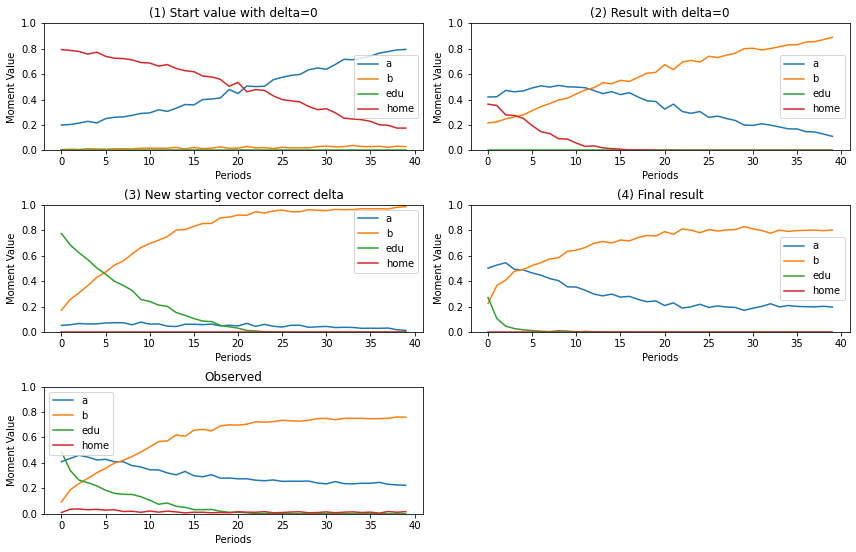

<IPython.core.display.Javascript object>

In [22]:
plot_moments(choices, 0, 1)

#### Wage Distribution

In [23]:
wages = get_moments_dict(
    params_dict=params_dict,
    simulate=simulate,
    empirical_moments=empirical_moments["Wage Distribution"],
    replace_nans=replace_nans,
    calc_moments=calc_moments["Wage Distribution"],
)

<IPython.core.display.Javascript object>

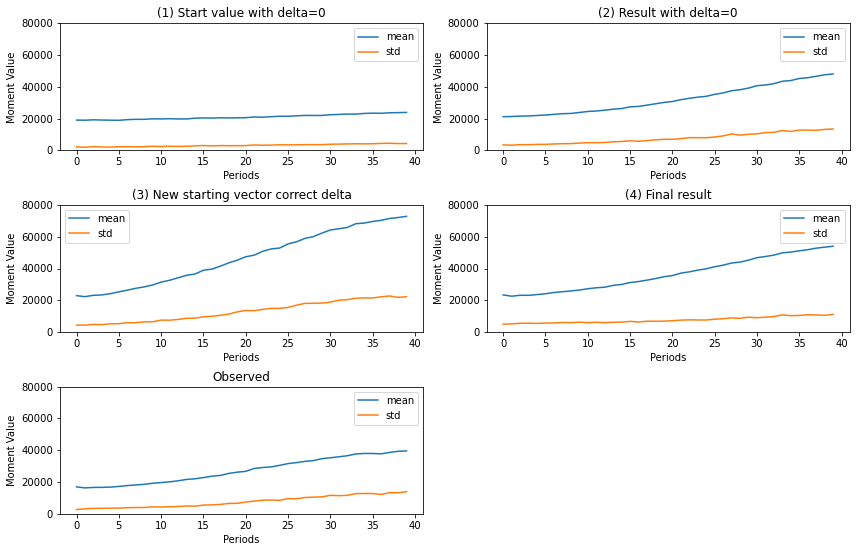

<IPython.core.display.Javascript object>

In [24]:
plot_moments(wages, 0, 80_000)

### Difference in Moments

We can also easily compute the difference in moments between the estimated and observed parameters. For the choices we just look at the total difference in choice frequencies for each period.

In [25]:
diff = {}
diff["Choice Frequencies"] = (
    empirical_moments["Choice Frequencies"] - choices["(4) Final result"]
)

<IPython.core.display.Javascript object>

For the wage distribution we compute the relative deviation compared to the values of the empirical moments.

In [26]:
diff["Wage Distribution"] = (
    empirical_moments["Wage Distribution"] - wages["(4) Final result"]
) / empirical_moments["Wage Distribution"]

<IPython.core.display.Javascript object>

Again, we can see that the overall result is close to the observed data. However, for the current estimates the number of individuals choosing education in earlier periods is too low and the number of individuals choosing to work is too high. Furthermore, our wages are consistently too high for every period.

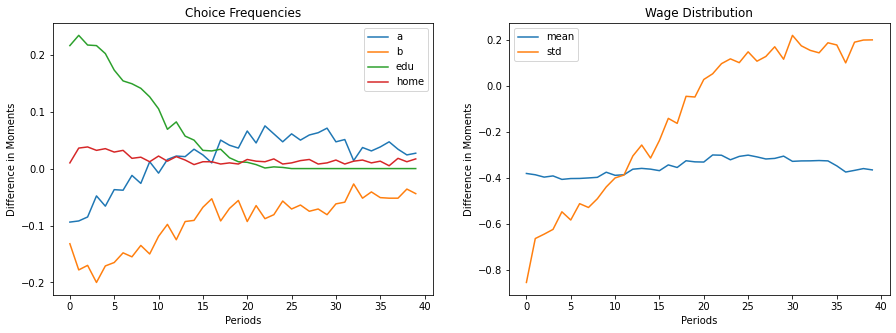

<IPython.core.display.Javascript object>

In [27]:
plt.figure(figsize=(15, 5))
plt.tight_layout()
for idx, key in enumerate(diff.keys()):
    plt.subplot(1, 2, idx + 1)
    plt.plot(diff[key])
    plt.legend(diff[key].columns, loc="best")
    plt.title(key)
    plt.xlabel("Periods")
    plt.ylabel("Difference in Moments")

### Parameter History

After assessing the criterion value and moment fit of th estimates, we now turn to the parameter values themselves. We can use the parameter history that `estimagic` saves in the logging databases during optimization to get a picture of how the estimates develop during the exercise and evaluate, which parameters change the most. 

In [28]:
database = load_database(logging_path + "/logging_away.db")
params_history = read_last_iterations(database, "params_history", 10_000, "pandas")
columns = params_history.columns[params_history.columns.str.contains("wage|nonpec")]

<IPython.core.display.Javascript object>

In [29]:
def plot_parameters(name):
    values = {}
    for db in ["away", "back"]:
        database = load_database(logging_path + "/logging_" + db + ".db")
        params_history = read_last_iterations(
            database, "params_history", 10_000, "pandas"
        )
        values[db] = params_history[name]
        true = params_history.iloc[0]

    values["back"].index = values["back"].index + max(values["away"].index)

    plt.plot(values["away"], label="away")
    plt.plot(values["back"], label="back")
    plt.ylabel("Parameter Value")
    plt.xlabel("Iterations")
    plt.title("Parameter History of: " + name)

    true = values["away"].iloc[0]

    if true == 0:
        lower, upper = -0.05, 0.05
    else:
        lower = true - abs(true * 0.05)
        upper = true + abs(true * 0.05)

    plt.hlines(
        [true, lower, upper],
        min(values["away"].index),
        max(values["back"].index),
        colors=["red", "yellow", "yellow"],
    )
    plt.legend()

<IPython.core.display.Javascript object>

The plots below show the parameter history of parameters that affect wages and the non-pecuniary rewards for education and the home option. Shocks and other parameters are purposely left out for legibility reasons. The red line indicates true parameter value and the yellow lines show the bounds set at the beginning of the exercise. The blue lines show the parameter history during optimization of the misspecified model and the orange line shows the second optimization process where we try to retrieve the true values. The plots reveal that most of these parameters did not change significantly during the whole exercise. The change in moments seems to be mainly driven  by the wage constants of the model which increasingly move towards the bounds during the exercise.

Seeing that the wage constants are quite high compared to the true model, it is not surprising that our current specification under-predicts the choice frequencies for the education and home option and over-predicts the choice frequencies of the working alternatives. In the next step we will thus attempt to correct this problem.

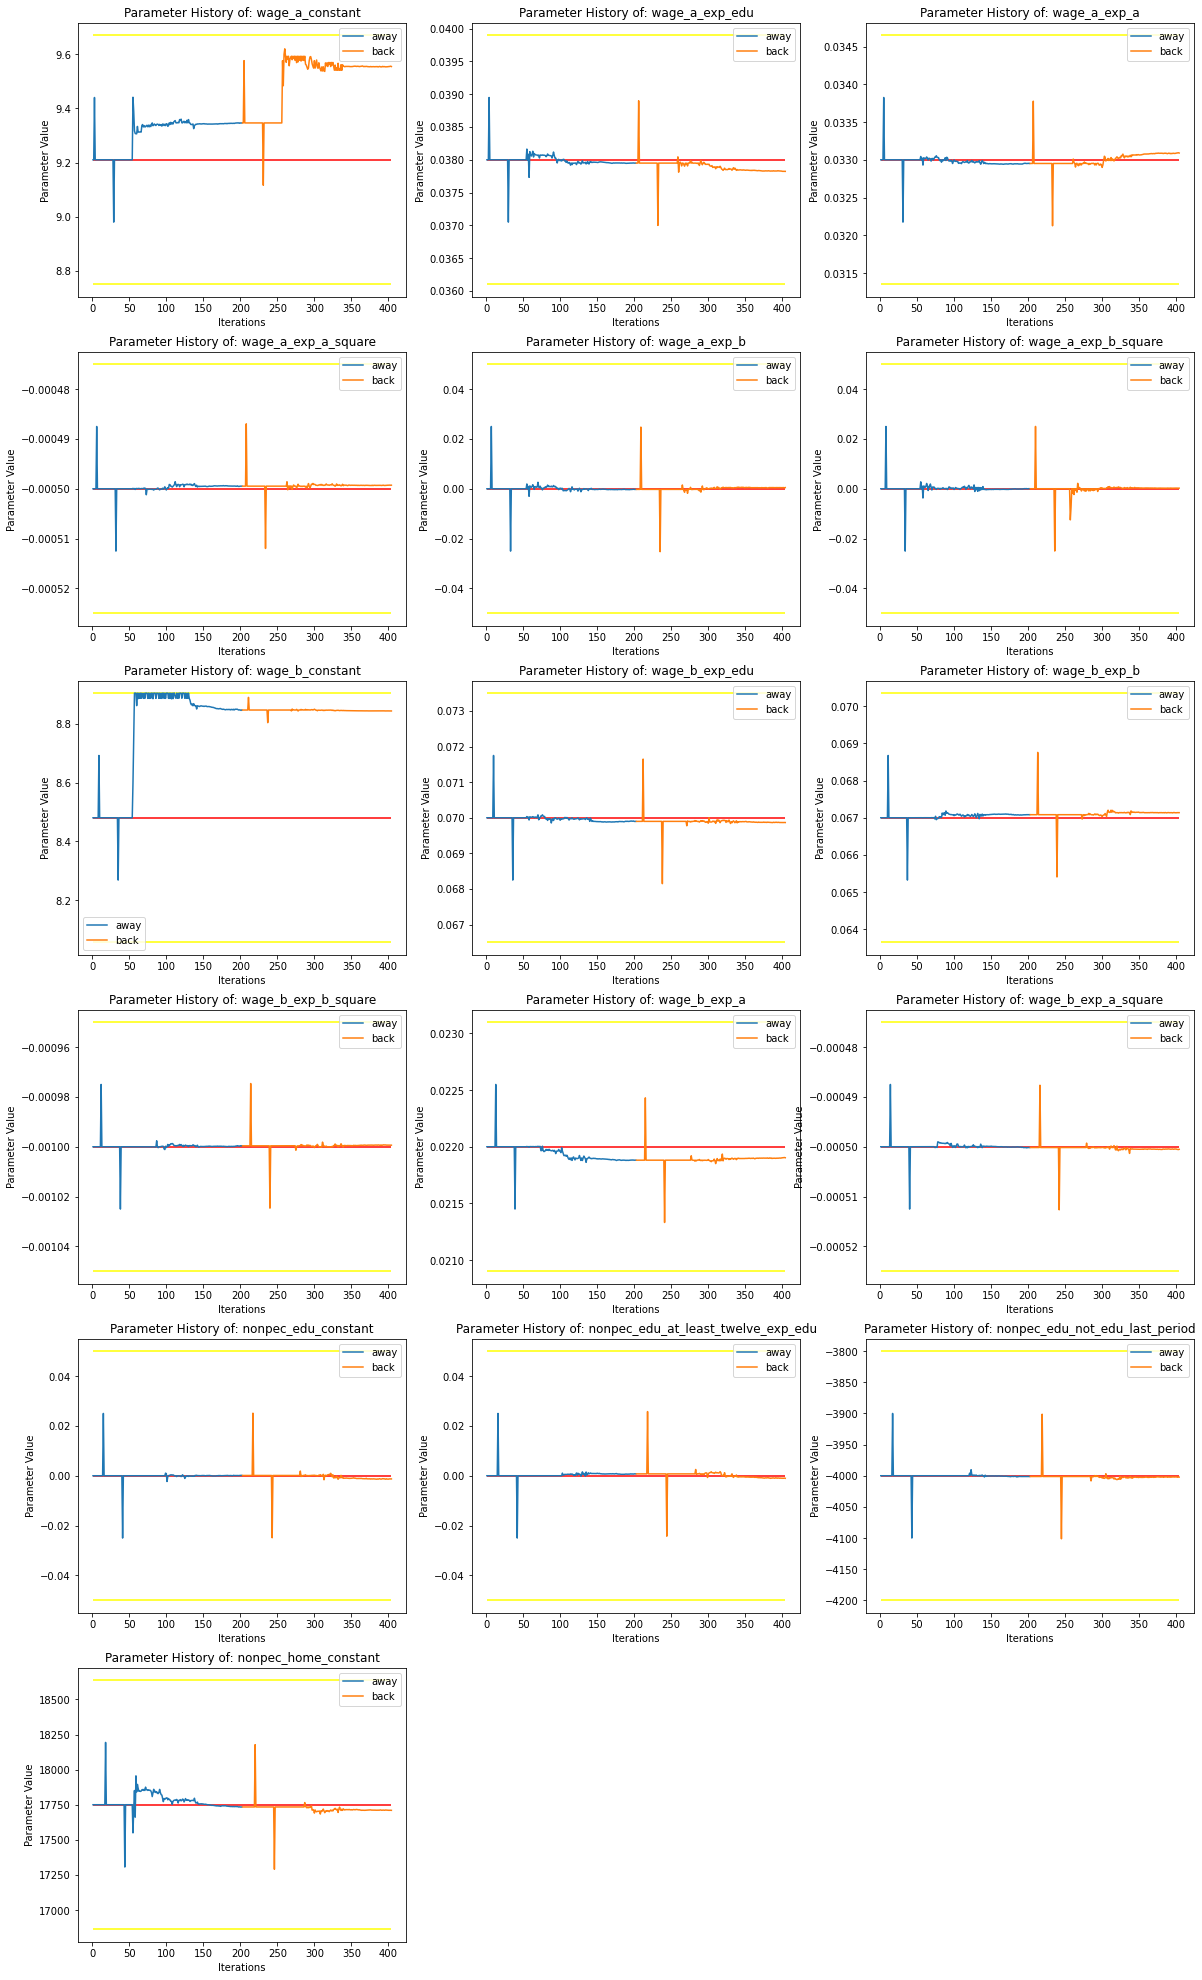

<IPython.core.display.Javascript object>

In [30]:
plt.figure(figsize=(20, 60))
for idx, name in enumerate(columns):
    plt.subplot(11, 3, idx + 1)
    plot_parameters(name)
    plt.subplots_adjust(top=0.95)

# Refining Estimation Results

The results from the exercise lead us to the conclusion, that the overall estimation mechanism seem to work well. The optimizer manages to select parameters that improve the match between simulated and empirical moments, even after being led into the wrong direction through a misspecified model. However, our results for the parameter estimates themselves are not satisfactory yet since the model over-predicts the choice frequencies of work options and under-predicts choice frequencies of the other alternatives. 

To refine the results, we will thus run an optimization yet again, this time only on the constants of the model. This allows the optimizer to focus only on these four parameters and will prevent it form trying to improve the fit through other parameters like shocks.

For the estimation we use the parameters from step (4) of the exercise as starting values and create new constraints that fix all parameters but the constants.

In [31]:
params_start = params_dict["(4) Final result"][["value", "lower", "upper"]]

<IPython.core.display.Javascript object>

In [32]:
constr = []
constr += [{"loc": "shocks_sdcorr", "type": "sdcorr"}]
# Fix all parameters.
for index in params_start.index:
    constr += [{"loc": index, "type": "fixed"}]
# Free up constants.
for item in constr:
    if "constant" in item["loc"]:
        constr.remove(item)

<IPython.core.display.Javascript object>

In [33]:
rslt_constants = minimize(
    criterion_msm,
    params=params_start,
    constraints=constr,
    logging="logging_constants.db",
    algorithm="nlopt_bobyqa",
    algo_options={"maxeval": 100},
)

<IPython.core.display.Javascript object>

The criterion value improves substantially.

In [34]:
print("Starting Criterion Value: ", round(criterion_msm(params_start), 1))
print("Result Criterion Value: ", round(criterion_msm(rslt_constants[1]), 1))

Starting Criterion Value:  85052.4
Result Criterion Value:  10110.4


<IPython.core.display.Javascript object>

The moment estimates also improved compared to the prior solution. 

In [35]:
simulate = rp.get_simulate_func(params_start, options)
data_sim = simulate(rslt_constants[1])
choices_sim = calc_choice_frequencies(data_sim)
wages_sim = calc_wage_distribution(data_sim)

<IPython.core.display.Javascript object>

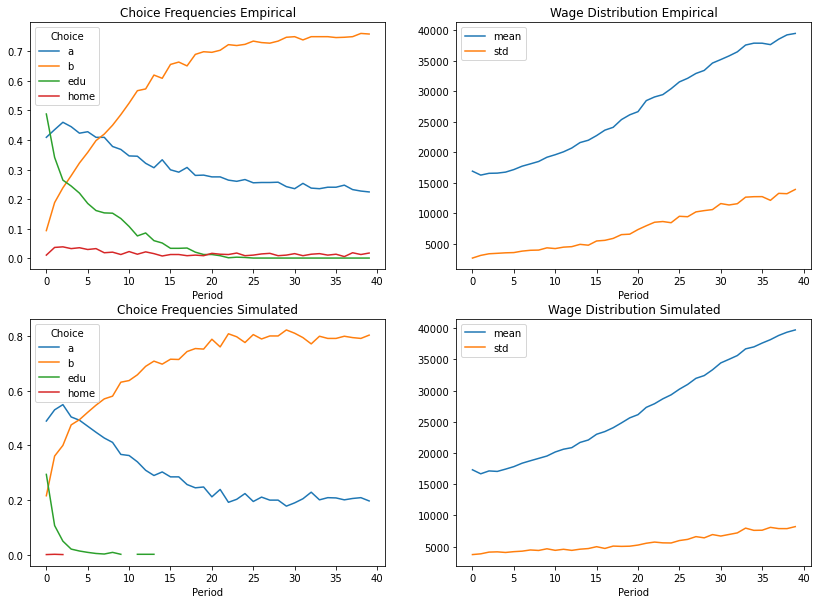

<IPython.core.display.Javascript object>

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
empirical_moments["Choice Frequencies"].plot(
    title="Choice Frequencies Empirical", ax=axes[0, 0]
)
empirical_moments["Wage Distribution"].plot(
    title="Wage Distribution Empirical", ax=axes[0, 1]
)
choices_sim.plot(title="Choice Frequencies Simulated", ax=axes[1, 0])
wages_sim.plot(title="Wage Distribution Simulated", ax=axes[1, 1])

Finally, after correcting the constants of the model, we can free up the other parameters for estimation one last time.

In [37]:
params_start = rslt_constants[1][["value", "lower", "upper"]]

<IPython.core.display.Javascript object>

In [38]:
constraints = rp.get_parameter_constraints("kw_94_one")
constraints += [{"loc": ("delta", "delta"), "type": "fixed"}]

<IPython.core.display.Javascript object>

In [39]:
rslt_refined = minimize(
    criterion_msm,
    params=params_start,
    constraints=constraints,
    logging="logging_refined.db",
    algorithm="nlopt_bobyqa",
    algo_options={"maxeval": 200},
)

<IPython.core.display.Javascript object>

The criterion value improves yet again and the simulated moments seem to match the observed moments fairly well, too. We can still see some discrepancies, especially for the choice frequencies of occupation `b` which could be removed through further fine-tuning. Adjustments could involve increasing the number of evaluations of the criterion function, focusing on more subsets of parameters like the constants, and perturbing the parameter vector to generate diverging starting values for the optimizer to try out. 

In [40]:
print("Starting Criterion Value: ", round(criterion_msm(params_start), 1))
print("Result Criterion Value: ", round(criterion_msm(rslt_refined[1]), 1))

Starting Criterion Value:  10110.4
Result Criterion Value:  3404.1


<IPython.core.display.Javascript object>

In [41]:
data_sim = simulate(rslt_refined[1])

<IPython.core.display.Javascript object>

In [42]:
choices_sim = calc_choice_frequencies(data_sim)
wages_sim = calc_wage_distribution(data_sim)

<IPython.core.display.Javascript object>

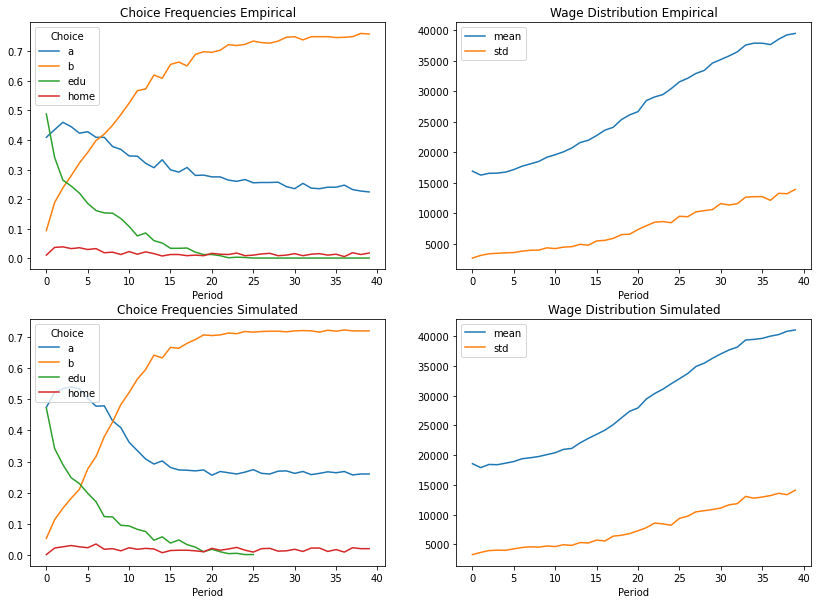

<IPython.core.display.Javascript object>

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
empirical_moments["Choice Frequencies"].plot(
    title="Choice Frequencies Empirical", ax=axes[0, 0]
)
empirical_moments["Wage Distribution"].plot(
    title="Wage Distribution Empirical", ax=axes[0, 1]
)
choices_sim.plot(title="Choice Frequencies Simulated", ax=axes[1, 0])
wages_sim.plot(title="Wage Distribution Simulated", ax=axes[1, 1])

## Additional Resources

Adda, J., & Cooper, R. W. (2003). *Dynamic Economics: Quantitative Methods and Applications*. MIT press.

Andrews, I., Gentzkow, M., & Shapiro, J. M. (2017). [Measuring the Sensitivity of Parameter Estimates to Estimation Moments](https://academic.oup.com/qje/article-abstract/132/4/1553/3861634?redirectedFrom=fulltext). The Quarterly Journal of Economics, 132(4), 1553-1592.

Davidson, R., & MacKinnon, J. G. (2004). *Econometric Theory and Methods (Vol. 5)*. New York: Oxford University Press. 

Evans, R. W. (2018, July 5). [Simulated Method of Moments (SMM) Estimation](https://notes.quantecon.org/submission/5b3db2ceb9eab00015b89f93). QuantEcon Notes.

Gourieroux, M., & Monfort, D. A. (1996). *Simulation-based econometric methods*. Oxford university press. 

Stern, S. (1997). [Simulation-based estimation](https://www.jstor.org/stable/2729885?seq=1). Journal of Economic Literature, 35(4), 2006-2039.


## References

Eisenhauer, P., Heckman, J. J., & Mosso, S. (2015). [Estimation of dynamic discrete choice models by maximum likelihood and the simulated method of moments](https://onlinelibrary.wiley.com/doi/abs/10.1111/iere.12107). International economic review, 56(2), 331-357.


Eisenhauer, P. (2019). [The approximate solution of finite‐horizon discrete‐choice dynamic programming models](https://onlinelibrary.wiley.com/doi/full/10.1002/jae.2648). Journal of Applied Econometrics, 34(1), 149-154.

Keane, M.P. and Wolpin, K.I. (1994). [The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence](https://www.jstor.org/stable/2109768?seq=1). The Review of Economics and Statistics, 76(4): 648-672.


McFadden, D. (1989). [A Method of Simulated Moments for Estimation of Discrete Response Models without Numerical Integration](https://www.jstor.org/stable/1913621?seq=1). Econometrica: Journal of the Econometric Society, 995-1026.